In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Importing Data From Yahoo Finance 
#### Tesla's Stock Data
#### 2-Jan-2020 To 30-Sept-2025

In [3]:
data = yf.download("TSLA", start = "2020-01-01", end = "2025-10-01", auto_adjust = False)

[*********************100%***********************]  1 of 1 completed


In [4]:
data.reset_index(inplace = True)

In [5]:
data

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
0,2020-01-02,28.684000,28.684000,28.713333,28.114000,28.299999,142981500
1,2020-01-03,29.534000,29.534000,30.266666,29.128000,29.366667,266677500
2,2020-01-06,30.102667,30.102667,30.104000,29.333332,29.364668,151995000
3,2020-01-07,31.270666,31.270666,31.441999,30.224001,30.760000,268231500
4,2020-01-08,32.809334,32.809334,33.232666,31.215334,31.580000,467164500
...,...,...,...,...,...,...,...
1439,2025-09-24,442.790009,442.790009,444.209991,429.029999,429.829987,93133600
1440,2025-09-25,423.390015,423.390015,435.350006,419.079987,435.239990,96746400
1441,2025-09-26,440.399994,440.399994,440.470001,421.019989,428.299988,101628200


## Data Cleaning

In [7]:
data.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
0,2020-01-02,28.684000,28.684000,28.713333,28.114000,28.299999,142981500
1,2020-01-03,29.534000,29.534000,30.266666,29.128000,29.366667,266677500
2,2020-01-06,30.102667,30.102667,30.104000,29.333332,29.364668,151995000
3,2020-01-07,31.270666,31.270666,31.441999,30.224001,30.760000,268231500
4,2020-01-08,32.809334,32.809334,33.232666,31.215334,31.580000,467164500


In [8]:
# Dropping unnecessary column 'Ticker'

data.columns = data.columns.droplevel(1)

In [9]:
# Checking for null values

data.isnull().sum()

Price
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [10]:
# Checking for duplicated values

data.duplicated().sum()

0

In [11]:
# Summary of data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1444 non-null   datetime64[ns]
 1   Adj Close  1444 non-null   float64       
 2   Close      1444 non-null   float64       
 3   High       1444 non-null   float64       
 4   Low        1444 non-null   float64       
 5   Open       1444 non-null   float64       
 6   Volume     1444 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 79.1 KB


In [12]:
data.set_index("Date",inplace = True)

In [13]:
# Statistical summary of the data

data.describe()

Price,Adj Close,Close,High,Low,Open,Volume
count,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03
mean,228.094549,228.094549,233.297391,222.649607,228.136766,1.226128e+08
std,88.885166,88.885166,90.870277,86.911873,89.044793,7.809240e+07
min,24.081333,24.081333,26.990667,23.367332,24.980000,2.940180e+07
25%,180.517494,180.517494,184.597504,176.827499,180.775002,7.618770e+07
50%,231.901672,231.901672,236.779999,225.596664,231.135002,1.005984e+08
75%,282.279991,282.279991,286.850838,275.142487,281.914993,1.403466e+08
max,479.859985,479.859985,488.540009,457.510010,475.899994,9.140820e+08


In [14]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-02,28.684000,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,32.809334,33.232666,31.215334,31.580000,467164500


## Exploratory Data Analysis (EDA) 

In [16]:
eda_data = data.reset_index()
eda_data["Month"] = eda_data["Date"].dt.month
eda_data["Year"] = eda_data["Date"].dt.year

In [17]:
eda_data.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume,Month,Year
0,2020-01-02,28.684000,28.684000,28.713333,28.114000,28.299999,142981500,1,2020
1,2020-01-03,29.534000,29.534000,30.266666,29.128000,29.366667,266677500,1,2020
2,2020-01-06,30.102667,30.102667,30.104000,29.333332,29.364668,151995000,1,2020
3,2020-01-07,31.270666,31.270666,31.441999,30.224001,30.760000,268231500,1,2020
4,2020-01-08,32.809334,32.809334,33.232666,31.215334,31.580000,467164500,1,2020


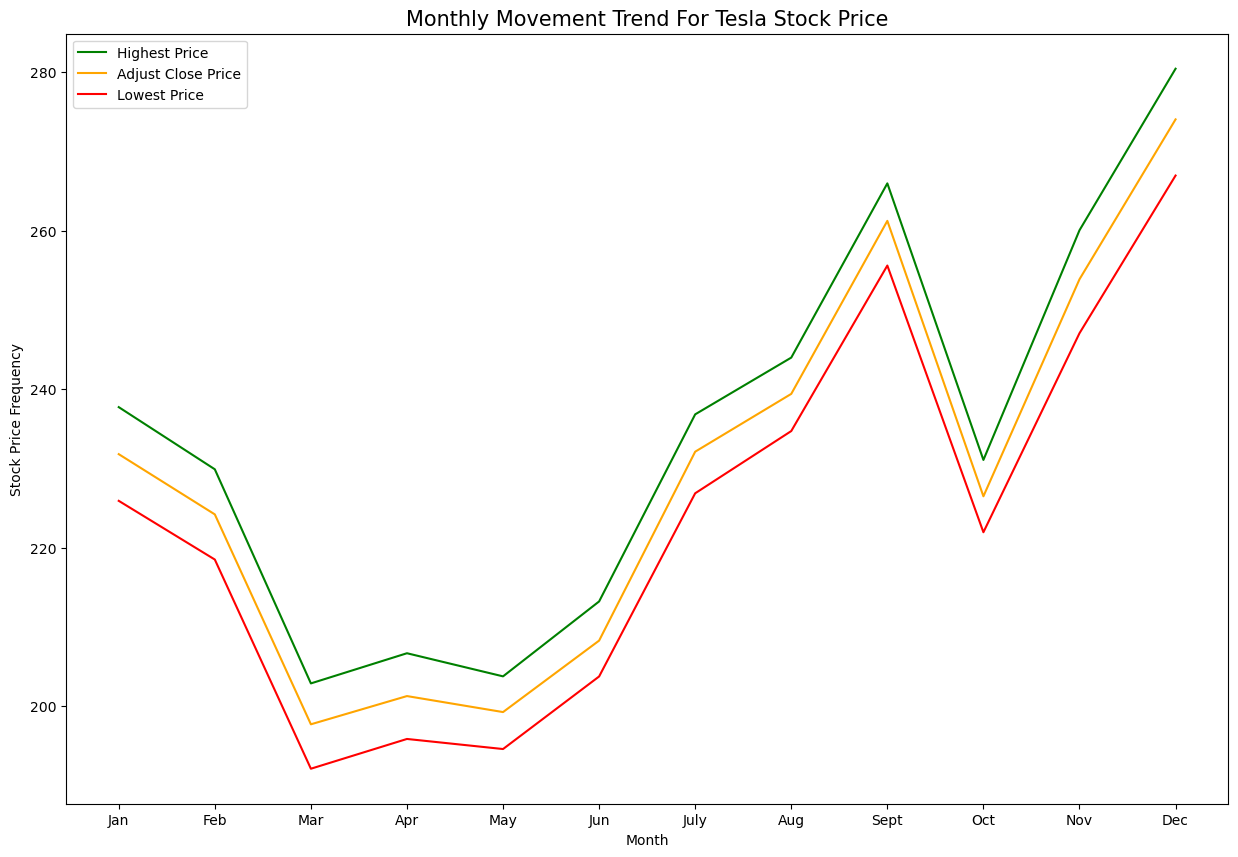

In [18]:
# Plotting monthly trend line

plt.figure(figsize = (15,10))
sns.lineplot(data = eda_data, x = eda_data["Month"], y = eda_data["High"], color = "green", errorbar = None)
sns.lineplot(data = eda_data, x = eda_data["Month"], y = eda_data["Adj Close"], color = "orange", errorbar = None)
sns.lineplot(data = eda_data, x = eda_data["Month"], y = eda_data["Low"], color = "red", errorbar = None)
plt.title("Monthly Movement Trend For Tesla Stock Price", fontsize = 15) 
plt.xlabel("Month")
plt.xticks(range(1,13),["Jan","Feb","Mar","Apr","May","Jun","July","Aug","Sept","Oct","Nov","Dec"])
plt.ylabel("Stock Price Frequency")
plt.legend(["Highest Price","Adjust Close Price","Lowest Price"])
plt.show()

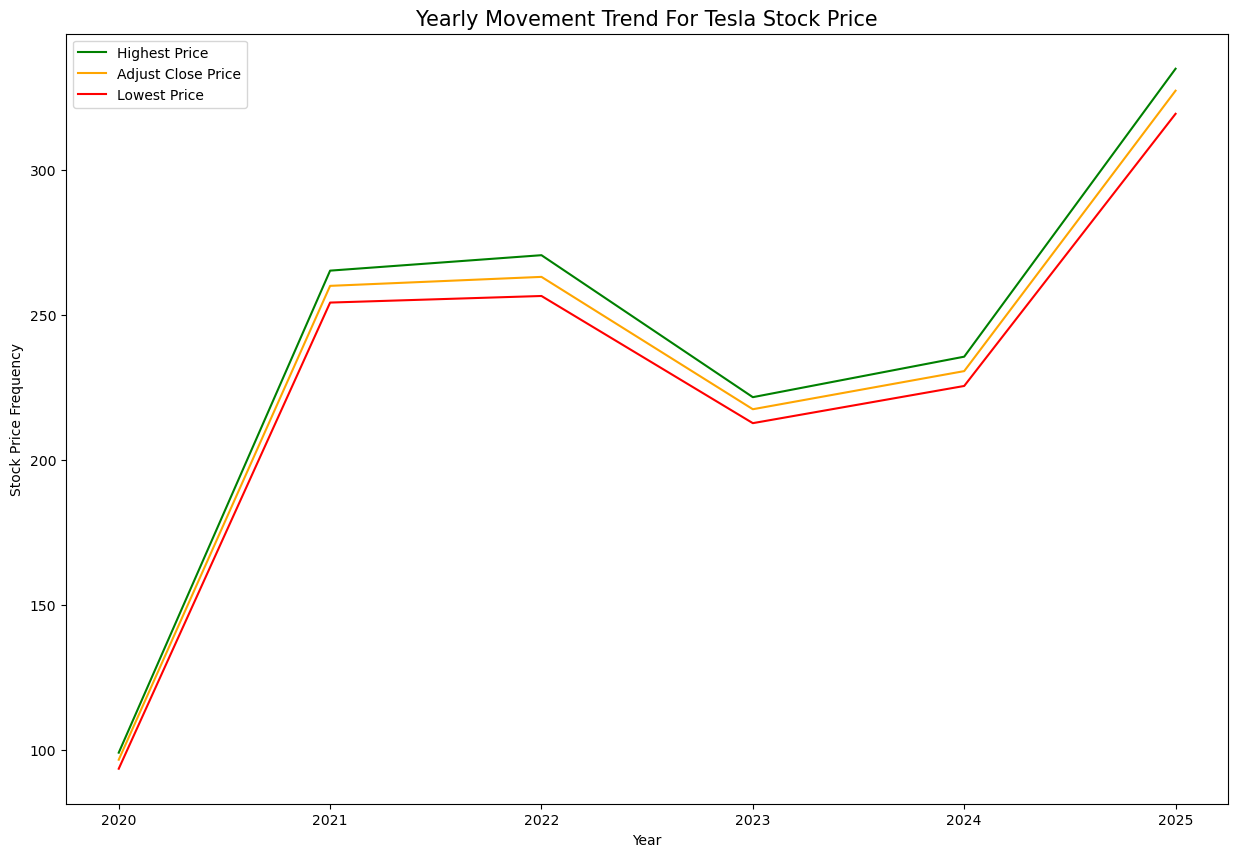

In [19]:
# Plotting yearly trend line

plt.figure(figsize = (15,10))
sns.lineplot(data = eda_data, x = eda_data["Year"], y = eda_data["High"], color = "green", errorbar = None)
sns.lineplot(data = eda_data, x = eda_data["Year"], y = eda_data["Adj Close"], color = "orange", errorbar = None)
sns.lineplot(data = eda_data, x = eda_data["Year"], y = eda_data["Low"], color = "red", errorbar = None)
plt.title("Yearly Movement Trend For Tesla Stock Price", fontsize = 15) 
plt.xlabel("Year")
plt.ylabel("Stock Price Frequency")
plt.legend(["Highest Price","Adjust Close Price","Lowest Price"])
plt.show()

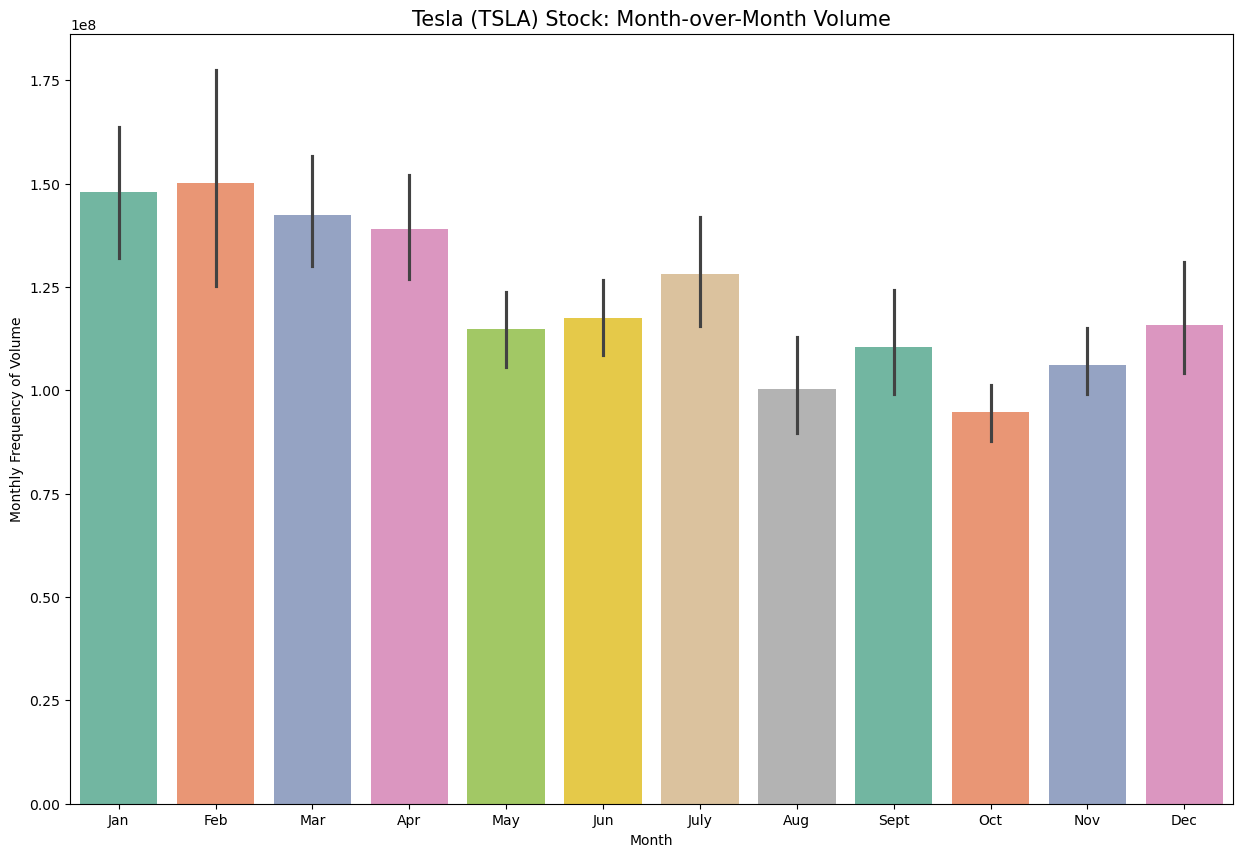

In [20]:
# Plotting month-over-month volume

plt.figure(figsize = (15,10))
sns.barplot(data = eda_data, x = eda_data["Month"], y = eda_data["Volume"], palette = "Set2")
plt.title("Tesla (TSLA) Stock: Month-over-Month Volume", fontsize = 15)
plt.xlabel("Month")
plt.ylabel("Monthly Frequency of Volume")
plt.xticks(range(0,12),["Jan","Feb","Mar","Apr","May","Jun","July","Aug","Sept","Oct","Nov","Dec"])
plt.show()

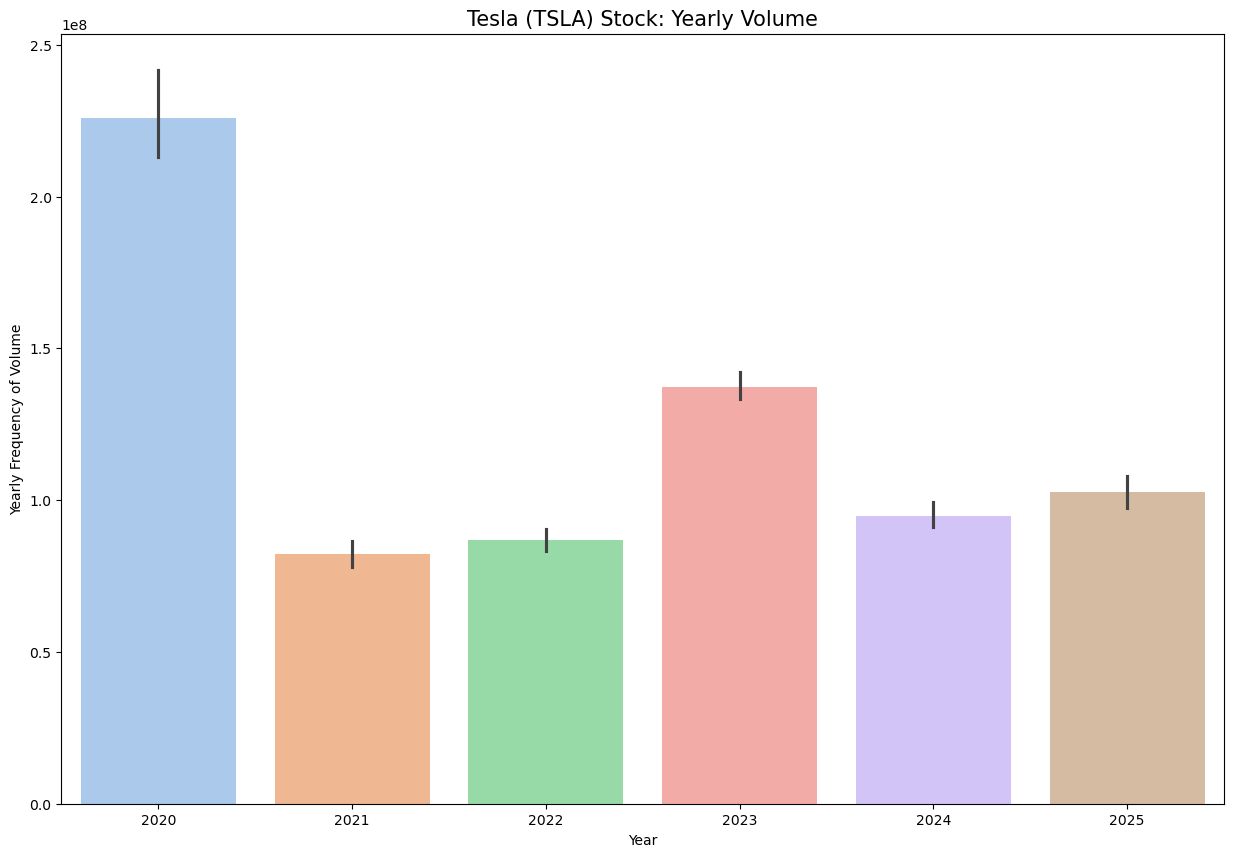

In [21]:
# Plotting year wise volume

plt.figure(figsize = (15,10))
sns.barplot(data = eda_data,x = eda_data["Year"], y = eda_data["Volume"], palette = "pastel")
plt.title("Tesla (TSLA) Stock: Yearly Volume", fontsize = 15)
plt.xlabel("Year")
plt.ylabel("Yearly Frequency of Volume")
plt.show()

## Visualise Data For Forecasting (Adjust Close)

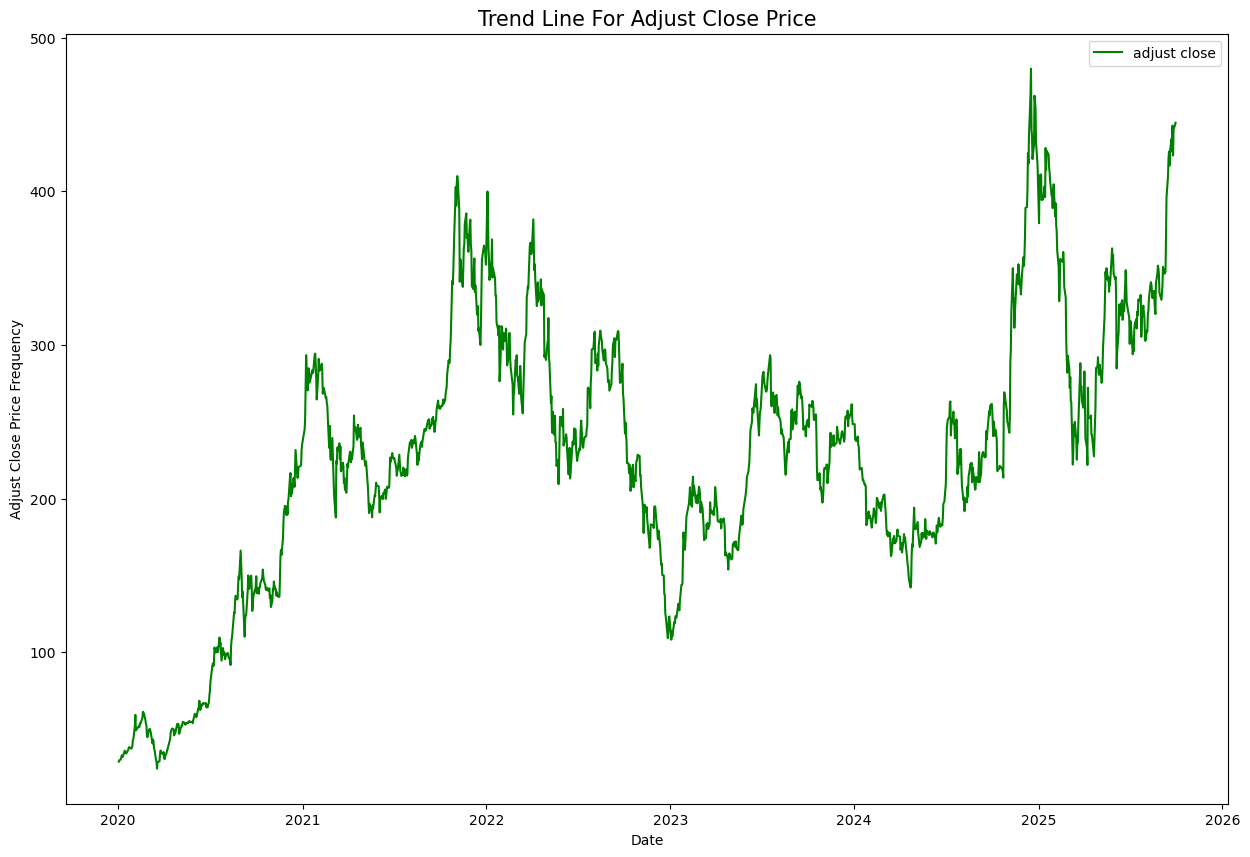

In [23]:
plt.figure(figsize = (15,10))
plt.plot(data["Adj Close"],label = "adjust close",color = "green")
plt.title("Trend Line For Adjust Close Price", fontsize = 15)
plt.xlabel("Date")
plt.ylabel("Adjust Close Price Frequency")
plt.legend()
plt.show()

#### Testing For Stationarity

In [25]:
result = adfuller(data["Adj Close"])
result

(-2.3208420512336403,
 0.16533407396427868,
 24,
 1419,
 {'1%': -3.434966750462565,
  '5%': -2.8635789736973725,
  '10%': -2.5678555388041384},
 10419.019359064492)

In [26]:
# H0 : It is Non-Stationary Data
# H1 : It is Stationary Data

def adfuller_test(adj_close):
    result = adfuller(adj_close)
    labels = ["ADF Test Statistic", "P-Value", "Legs Used", "Number of Observation Used"]
    for value,label in zip(result,labels):
        print(f"{label} : {value}")
    if result[1] > 0.05:
        print("H0 is Accepted, It's Non-Stationary Data")
    else:
        print("H0 is Rejected, It's Stationary Data")

In [27]:
adfuller_test(data["Adj Close"])

ADF Test Statistic : -2.3208420512336403
P-Value : 0.16533407396427868
Legs Used : 24
Number of Observation Used : 1419
H0 is Accepted, It's Non-Stationary Data


#### Differencing

In [29]:
forecast_df = pd.DataFrame(index = data.index , data = data["Adj Close"])

In [30]:
forecast_df.head()

,Adj Close
Date,
2020-01-02,28.684000
2020-01-03,29.534000
2020-01-06,30.102667
2020-01-07,31.270666
2020-01-08,32.809334


In [31]:
forecast_df["Adj Close First Difference"] = forecast_df["Adj Close"] - forecast_df["Adj Close"].shift(1)

In [32]:
forecast_df

,Adj Close,Adj Close First Difference
Date,,
2020-01-02,28.684000,NaN
2020-01-03,29.534000,0.850000
2020-01-06,30.102667,0.568666
2020-01-07,31.270666,1.167999
2020-01-08,32.809334,1.538668
...,...,...
2025-09-24,442.790009,16.940002
2025-09-25,423.390015,-19.399994
2025-09-26,440.399994,17.009979


In [33]:
# Again testing dickey fuller test
adfuller_test(forecast_df["Adj Close First Difference"].dropna())

ADF Test Statistic : -6.57535893750927
P-Value : 7.750056858782406e-09
Legs Used : 23
Number of Observation Used : 1419
H0 is Rejected, It's Stationary Data


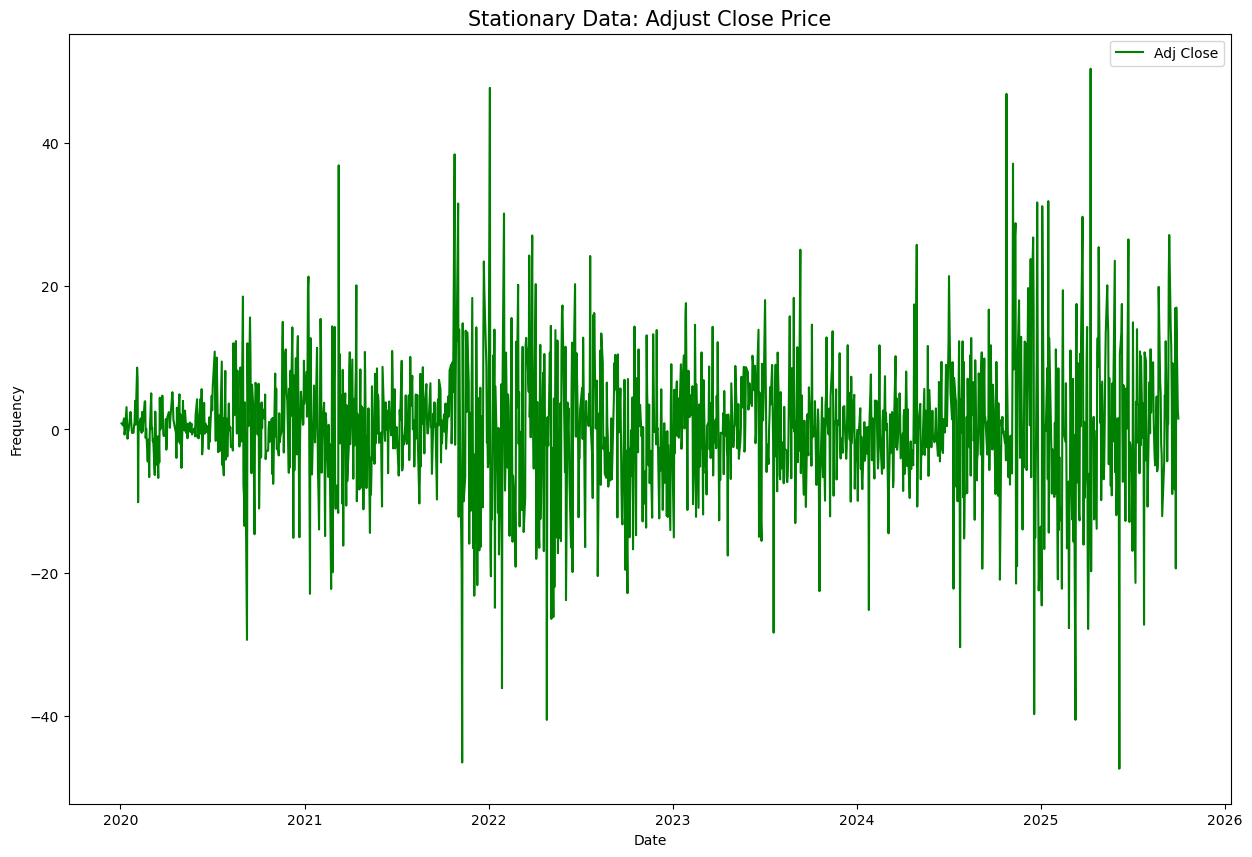

In [34]:
# Plotting stationary data

plt.figure(figsize = (15,10))
plt.plot(forecast_df["Adj Close First Difference"],label = "Adj Close", color = "green")
plt.title("Stationary Data: Adjust Close Price", fontsize = 15)
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Autocorrelation and Partial Autocorrelation 

- Identification of an AR model is often best done with the PACF.
- Identification of an MA model is often best done with the ACF rather than the PACF.
- ``order:`` p,d,q

    - p : AR Model Legs (Autoregrassive)
    - d : Differencing/Integration (Integrated) 
    - q : MA Model Legs (Moving Average)

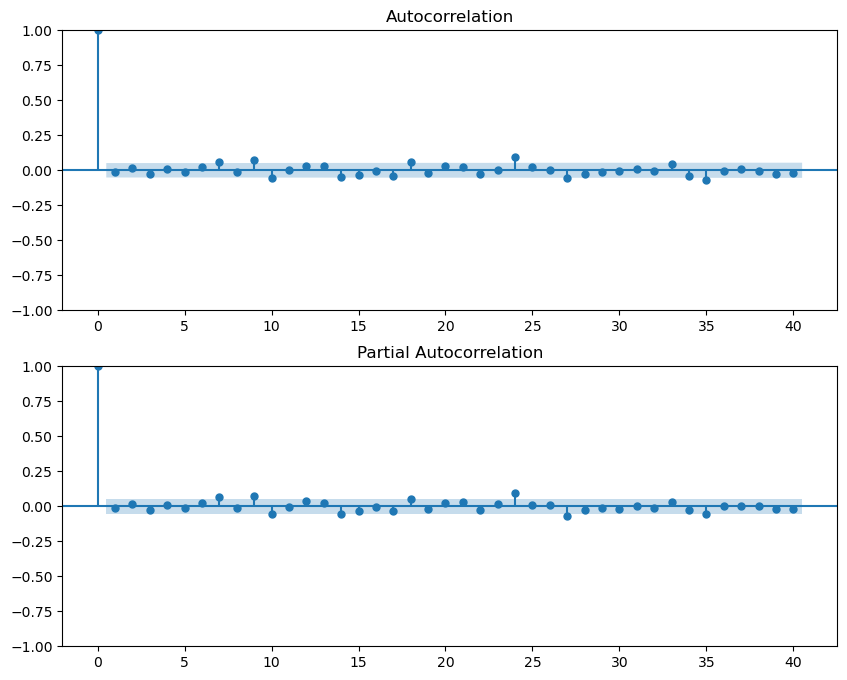

In [37]:
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(forecast_df["Adj Close First Difference"].iloc[1:], lags = 40,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(forecast_df["Adj Close First Difference"].iloc[1:], lags = 40,ax = ax2)

## Forecast

In [39]:
# Fitting ARIMA model for forecast 
model = ARIMA(forecast_df["Adj Close"], order = (1,1,1))
model_fit = model.fit()

In [40]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1444
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5290.623
Date:                Mon, 13 Oct 2025   AIC                          10587.246
Time:                        10:24:13   BIC                          10603.069
Sample:                             0   HQIC                         10593.152
                               - 1444                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6128      0.628     -0.976      0.329      -1.843       0.618
ma.L1          0.5936      0.639      0.929      0.353      -0.659       1.846
sigma2        89.5621      1.989     45.039      0.000      85.665      93.460
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               803.13
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

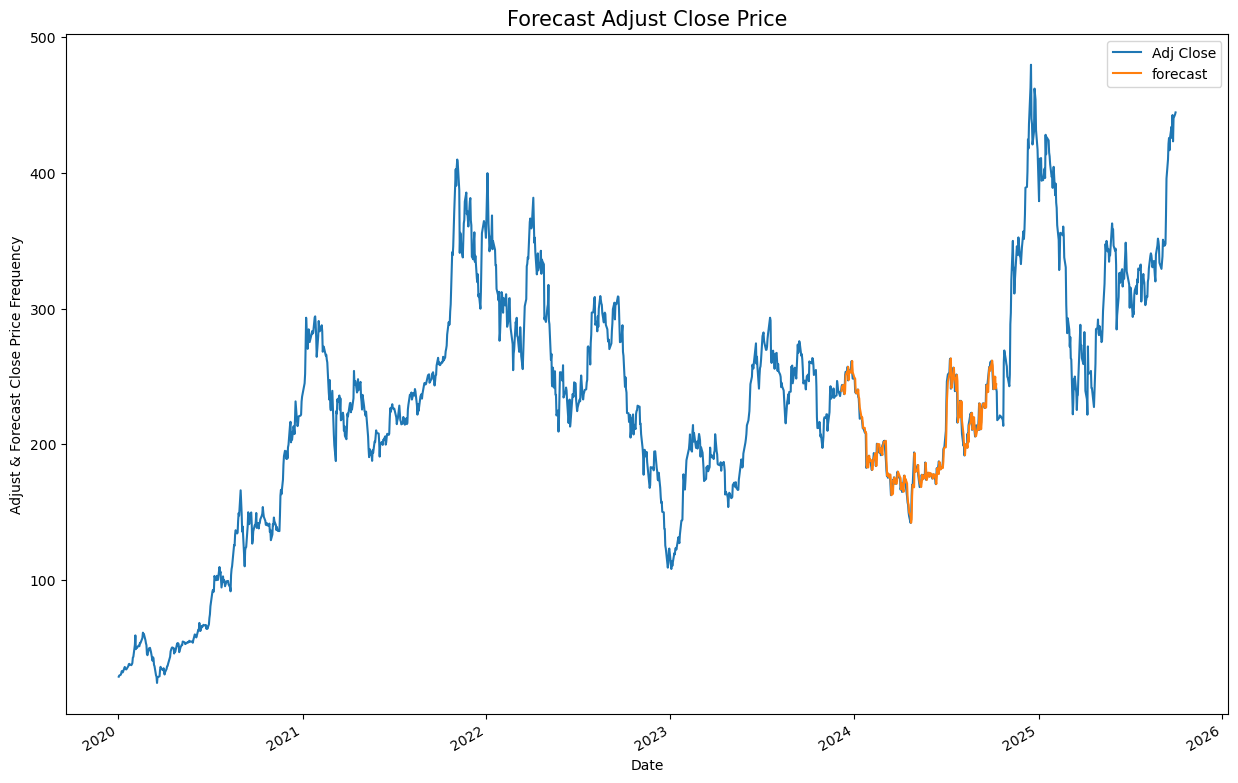

In [41]:
# Plotting forecast for few steps

forecast_df["forecast"] = model_fit.predict(start= 990,end = 1200,dynamic = False)
forecast_df[["Adj Close","forecast"]].plot(figsize = (15,10))
plt.title("Forecast Adjust Close Price", fontsize = 15)
plt.xlabel("Date")
plt.ylabel("Adjust & Forecast Close Price Frequency")
plt.legend()
plt.show()

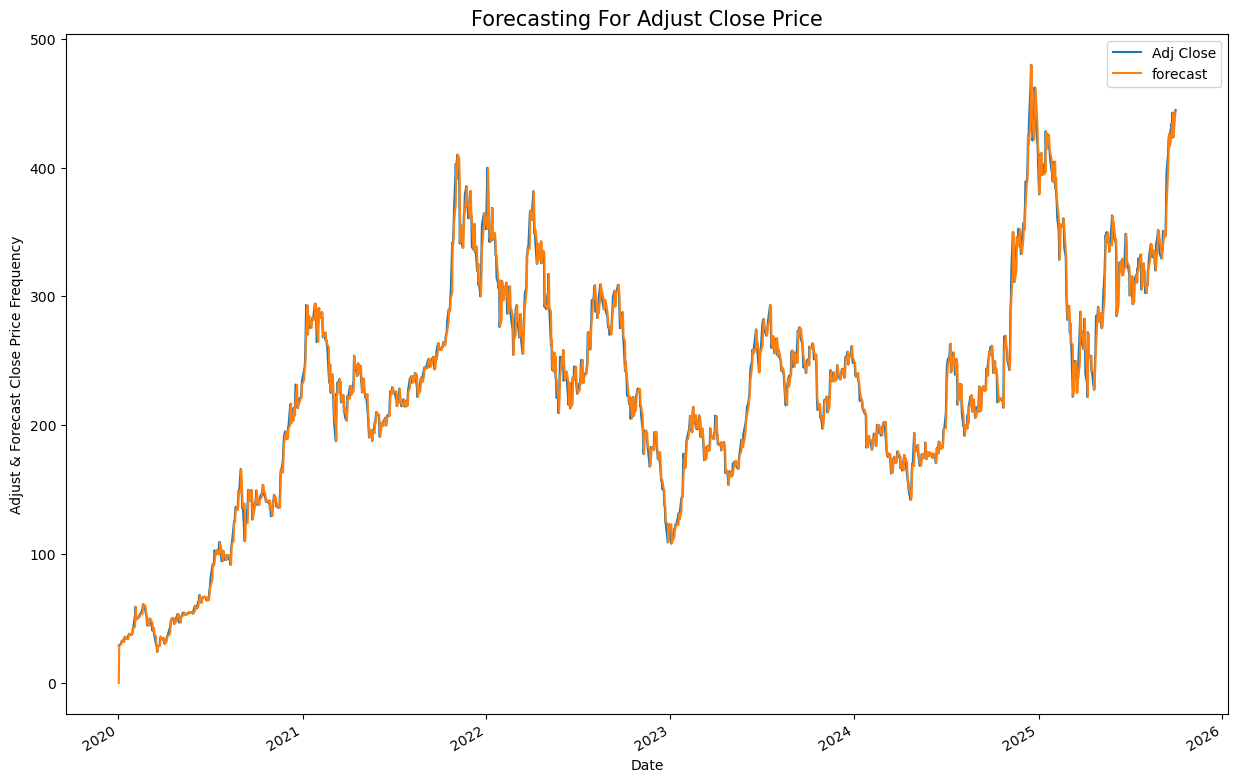

In [42]:
# Plot forecasting for whole data

forecast_df["forecast"] = model_fit.predict(start= 0,end = 1443,dynamic = False)
forecast_df[["Adj Close","forecast"]].plot(figsize = (15,10))
plt.title("Forecasting For Adjust Close Price", fontsize = 15)
plt.xlabel("Date")
plt.ylabel("Adjust & Forecast Close Price Frequency")
plt.legend()
plt.show()

In [43]:
forecast_df

,Adj Close,Adj Close First Difference,forecast
Date,,,
2020-01-02,28.684000,NaN,0.000000
2020-01-03,29.534000,0.850000,28.683950
2020-01-06,30.102667,0.568666,29.517481
2020-01-07,31.270666,1.167999,30.101528
2020-01-08,32.809334,1.538668,31.248957
...,...,...,...
2025-09-24,442.790009,16.940002,426.005250
2025-09-25,423.390015,-19.399994,442.373913
2025-09-26,440.399994,17.009979,424.008003


In [116]:
# Export data for preparing dashboard

eda_data.to_csv("Cleaned_Financial Data.csv", index = False)
forecast_df.to_csv("Forecast_Financial Data.csv")

## Evaluation

In [45]:
adjust_close = forecast_df["Adj Close"]
forecast = forecast_df["forecast"]

In [46]:
#  Evaluate root mean square error

mse = mean_squared_error(adjust_close,forecast)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 9.49051810569826


## Insights

``Summary Insights:``
- Tesla’s stock showed a steady upward trend from 2020–2025 with periodic volatility.
- Data was clean and consistent, requiring no major preprocessing.
- After differencing, the series became stationary, suitable for forecasting.
- The ARIMA(1,1,1) model performed well (RMSE ≈ 9.5), capturing overall price movements accurately.
- Forecast results indicate a continued moderate rise in Tesla’s stock with short-term fluctuations.
- Overall, the analysis reflects strong growth momentum and stable long-term performance.